# User Retention 
Calculate user retention in each subreddit (Figure 5)

In [1]:

import os
from itertools import groupby

os.chdir('/homes/gws/taugust/Projects/ARK/community_guidelines')
%run Reddit/SRILM_building_funcs.ipynb


/homes/gws/taugust/Projects/ARK/community_guidelines


In [2]:
def len_iter(items):
    return sum(1 for _ in items)

def consecutives(data):
    try:
        return max(len_iter(run) for val, run in groupby(data, lambda x: x > 0) if val)
    except ValueError: 
        return None

def get_tenure(row):
    non_zero = row[1].to_numpy().nonzero()[0]
    return (non_zero.max() - non_zero.min()) + 1
    
    
def return_sub_retention(sub, year, kind=None):
    df_author_counts = pd.read_csv('data/cleaned/sub_author_counts/'+sub+'_author_counts_'+year+'.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
    if kind is not None:
        df_author_counts = df_author_counts[df_author_counts['kind'] == kind]
    retained_authors = get_num_retained_authors(df_author_counts)
    first_time_retained_authors = get_new_author_num_retained(df_author_counts)
    return retained_authors, first_time_retained_authors


def get_num_retained_authors(df_author_counts):
    month_pairs = list(zip(range(1, 12), range(2, 13)))
    retained_authors = []

    for (month, next_month) in month_pairs:
        # get authors who just wrote in the first month
        df_author_first_month = df_author_counts[df_author_counts[str(month)] > 0]
        # get authors who wrote in both months of the month pair
        df_author_retained = df_author_counts[(df_author_counts[[str(month), str(next_month)]] > 0).sum(axis=1) == 2]
        # get percent of authors who posted in both months
        retained_authors.append(len(df_author_retained)/len(df_author_first_month))
        
    return retained_authors

def get_new_author_num_retained(df_author_counts):
    month_pairs = list(zip(range(1, 12), range(2, 13)))
    retained_authors = []

    for (month, next_month) in month_pairs:
        prev_months = range(1, month)
        
        # ignore all authors who never wrote before this month
        df_first_time_authors =  df_author_counts[df_author_counts[[str(prev_m) for prev_m in prev_months]].sum(axis=1) == 0]
        # get authors who just wrote in the first month
        df_author_first_month = df_first_time_authors[df_first_time_authors[str(month)] > 0]
        # get authors who wrote in both months of the month pair
        df_author_retained = df_first_time_authors[(df_first_time_authors[[str(month), str(next_month)]] > 0).sum(axis=1) == 2]
        retained_authors.append(len(df_author_retained)/len(df_author_first_month))
        
    return retained_authors

# # across all months
# def get_new_author_num_retained_full(sub, year, kind=None):
    
#     df_author_counts = pd.read_csv('data/cleaned/sub_author_counts/'+sub+'_author_counts_'+year+'.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
#     if kind is not None:
#         df_author_counts = df_author_counts[df_author_counts['kind'] == kind]
        
#     month_pairs = list(zip(range(1, 12), range(2, 13)))
#     retained_authors = []

#     # go one short so last one isn't always 0
#     for month in range(1, 12):
        
#         prev_months = range(1, month)
#         subs_months = range(month+1, 13)
        
#         # ignore all authors who never wrote before this month
#         df_first_time_authors =  df_author_counts[df_author_counts[[str(prev_m) for prev_m in prev_months]].sum(axis=1) == 0]
        
#         # get authors who wrote in the current month 
#         df_author_first_month = df_first_time_authors[df_first_time_authors[str(month)] > 0]
        
#         # get all authors who wrote in this month and at least one later month
#         df_author_retained =  df_author_first_month[df_author_first_month[[str(subs_m) for subs_m in subs_months]].sum(axis=1) >= 1]

#         retained_authors.append(len(df_author_retained)/len(df_author_first_month))
        
#     return retained_authors


    


In [3]:
rows = []
subs = ['news', 'politics', 'pics', 'funny', 'AskReddit', 'AskHistorians', 'EverythingScience', 'Futurology', 'science', 'TrueReddit', 'dataisbeautiful', 'askscience']

year = '2018'
for s in subs:
    
    # retention
    full_retention, new_time_retention = return_sub_retention(s, year=year, kind=None)
    rows.extend({'sub':s, 'kind':'new_retention', 'val':ret} for ret in new_time_retention)
    rows.extend({'sub':s, 'kind':'full_retention', 'val':ret} for ret in full_retention)


df_rows = pd.DataFrame(rows)


In [4]:
df_rows.groupby(['sub'])['val'].mean()

sub
AskHistorians        0.130992
AskReddit            0.358515
EverythingScience    0.180196
Futurology           0.176129
TrueReddit           0.250871
askscience           0.107585
dataisbeautiful      0.114215
funny                0.258895
news                 0.290381
pics                 0.230313
politics             0.398229
science              0.146408
Name: val, dtype: float64

In [5]:
df_rows['is_science'] = df_rows['sub'] == 'science'

df_full_retention = df_rows[df_rows['kind'] == 'full_retention']
df_new_retention = df_rows[df_rows['kind'] == 'new_retention']



In [7]:
def print_stats(df, s):
    print(s, df[df['sub'] == s]['val'].mean(), df[df['sub'] == s]['val'].std())

In [9]:
for s in subs:
    print_stats(df_rows, s)

news 0.29038116959995475 0.12198674871262684
politics 0.39822931729348204 0.155043162332131
pics 0.2303127820914552 0.08630701574102805
funny 0.2588948276059886 0.09184020324665103
AskReddit 0.35851463011494983 0.12000518425653733
AskHistorians 0.13099221535792396 0.05457900114725273
EverythingScience 0.18019591442120042 0.060748144321621886
Futurology 0.17612900211588242 0.06748037673789004
science 0.14640775123613883 0.05212563019727577
TrueReddit 0.2508708357643949 0.10378963104776973
dataisbeautiful 0.11421496549227123 0.04201290190552677
askscience 0.10758452284046909 0.04557825053987422


In [ ]:
df_retention[df_retention['sub'] == 'science']['val'].mean(), df_retention[df_retention['sub'] == 'science']['val'].std()

In [ ]:
# df_tenure[df_tenure['sub'] == 'science']['val'].mean(), df_tenure[df_tenure['sub'] == 'science']['val'].std()

In [11]:
# run anovas for this

df_ret_full_pivot = df_full_retention.drop(['kind', 'is_science'], axis=1).pivot(index=None, columns='sub', values='val')
df_ret_new_pivot = df_new_retention.drop(['kind', 'is_science'], axis=1).pivot(index=None, columns='sub', values='val')


run_anova([df_ret_full_pivot[s].dropna().values for s in subs], False)
run_anova([df_ret_new_pivot[s].dropna().values for s in subs], False)




F (  11 ,  120 ) = 765.124  p = 0.0000000000
F (  11 ,  120 ) = 13.818  p = 0.0000000000


In [12]:
def run_ttest(df, s1, s2):
    df_1 = df[df['sub'] == s1]['val']
    df_2 = df[df['sub'] == s2]['val']
    t, p = stats.ttest_ind(df_1, df_2)
    print(s1, s2, 't_{', len(s1), '}=', t,  'p=', p, 'd=', cohens_d(df_1, df_2))

In [14]:

for s2 in ['AskReddit', 'funny', 'politics']:
    run_ttest(df_full_retention, 'science', s2)

science AskReddit t_{ 7 }= -42.40733519516254 p= 4.5880640259350216e-21 d= -18.082548484682288
science funny t_{ 7 }= -21.4695993668123 p= 2.777964148824625e-15 d= -9.154667929744686
science politics t_{ 7 }= -36.486289809555394 p= 8.951288583671921e-20 d= -15.55780624911124


In [16]:

display(sp.posthoc_ttest(df_full_retention, val_col='val', group_col='sub', p_adjust='holm'))
display(sp.posthoc_ttest(df_new_retention, val_col='val', group_col='sub', p_adjust='holm'))



,AskHistorians,AskReddit,EverythingScience,Futurology,TrueReddit,askscience,dataisbeautiful,funny,news,pics,politics,science
AskHistorians,-1.000000e+00,1.563554e-21,4.844639e-08,1.031840e-07,1.357940e-15,2.314452e-05,1.574419e-04,7.427751e-16,1.775083e-18,3.700625e-14,4.059660e-19,2.439560e-01
AskReddit,1.563554e-21,-1.000000e+00,1.230213e-19,5.770401e-19,2.005825e-13,1.597234e-23,3.232609e-22,6.264462e-14,8.152269e-10,2.454263e-16,9.490881e-07,2.661077e-19
EverythingScience,4.844639e-08,1.230213e-19,-1.000000e+00,1.000000e+00,2.827861e-12,3.040599e-12,4.142808e-11,1.783190e-12,5.298832e-16,8.857250e-10,1.085064e-17,3.459341e-05
Futurology,1.031840e-07,5.770401e-19,1.000000e+00,-1.000000e+00,8.620022e-12,1.016340e-11,1.066961e-10,6.281994e-12,1.983288e-15,3.600446e-09,2.056363e-17,4.072388e-05
TrueReddit,1.357940e-15,2.005825e-13,2.827861e-12,8.620022e-12,-1.000000e+00,9.710134e-18,8.012643e-17,1.000000e+00,9.652201e-07,4.975677e-05,1.271667e-13,1.314535e-13
askscience,2.314452e-05,1.597234e-23,3.040599e-12,1.016340e-11,9.710134e-18,-1.000000e+00,1.000000e+00,4.168315e-18,1.709507e-20,7.741801e-17,3.457764e-20,5.457453e-06
dataisbeautiful,1.574419e-04,3.232609e-22,4.142808e-11,1.066961e-10,8.012643e-17,1.000000e+00,-1.000000e+00,4.277331e-17,2.063724e-19,9.624956e-16,1.020329e-19,3.281917e-05
funny,7.427751e-16,6.264462e-14,1.783190e-12,6.281994e-12,1.000000e+00,4.168315e-18,4.277331e-17,-1.000000e+00,2.901604e-07,5.160561e-05,7.269572e-14,9.722875e-14
news,1.775083e-18,8.152269e-10,5.298832e-16,1.983288e-15,9.652201e-07,1.709507e-20,2.063724e-19,2.901604e-07,-1.000000e+00,3.392580e-11,1.858360e-11,2.063500e-16
pics,3.700625e-14,2.454263e-16,8.857250e-10,3.600446e-09,4.975677e-05,7.741801e-17,9.624956e-16,5.160561e-05,3.392580e-11,-1.000000e+00,2.171855e-15,7.759791e-12


,AskHistorians,AskReddit,EverythingScience,Futurology,TrueReddit,askscience,dataisbeautiful,funny,news,pics,politics,science
AskHistorians,-1.000000,0.000081,0.423422,1.000000,0.094589,1.000000,1.000000,0.005478,0.062170,0.089293,0.000674,1.000000
AskReddit,0.000081,-1.000000,0.003503,0.002352,0.139798,0.000020,0.000044,0.341903,1.000000,0.089293,1.000000,0.000269
EverythingScience,0.423422,0.003503,-1.000000,1.000000,1.000000,0.059430,0.219178,0.515418,1.000000,1.000000,0.015174,1.000000
Futurology,1.000000,0.002352,1.000000,-1.000000,1.000000,0.325074,0.884384,0.325074,0.713198,1.000000,0.009784,1.000000
TrueReddit,0.094589,0.139798,1.000000,1.000000,-1.000000,0.018969,0.054619,1.000000,1.000000,1.000000,0.219178,0.392498
askscience,1.000000,0.000020,0.059430,0.325074,0.018969,-1.000000,1.000000,0.000751,0.018310,0.015602,0.000217,0.884384
dataisbeautiful,1.000000,0.000044,0.219178,0.884384,0.054619,1.000000,-1.000000,0.002352,0.042016,0.047114,0.000434,1.000000
funny,0.005478,0.341903,0.515418,0.325074,1.000000,0.000751,0.002352,-1.000000,1.000000,1.000000,0.450357,0.029542
news,0.062170,1.000000,1.000000,0.713198,1.000000,0.018310,0.042016,1.000000,-1.000000,1.000000,1.000000,0.207386
pics,0.089293,0.089293,1.000000,1.000000,1.000000,0.015602,0.047114,1.000000,1.000000,-1.000000,0.157818,0.392498


In [ ]:
df_science_ret = df_retention[df_retention['sub'] == 'science']
df_not_science_ret = df_retention[df_retention['sub'] != 'science']

# df_science_ten = df_tenure[df_tenure['sub'] == 'science']
# df_not_science_ten = df_tenure[df_tenure['sub'] != 'science']

print('retention', stats.mannwhitneyu(df_science_ret['val'], df_not_science_ret['val']))

# print('tenure', stats.mannwhitneyu(df_science_ten['val'], df_not_science_ten['val']))


In [17]:
retention_order = df_full_retention.groupby(['sub'])['val'].mean().sort_values().index.to_list()
retention_order.remove('science')
retention_order.insert(0, 'science')


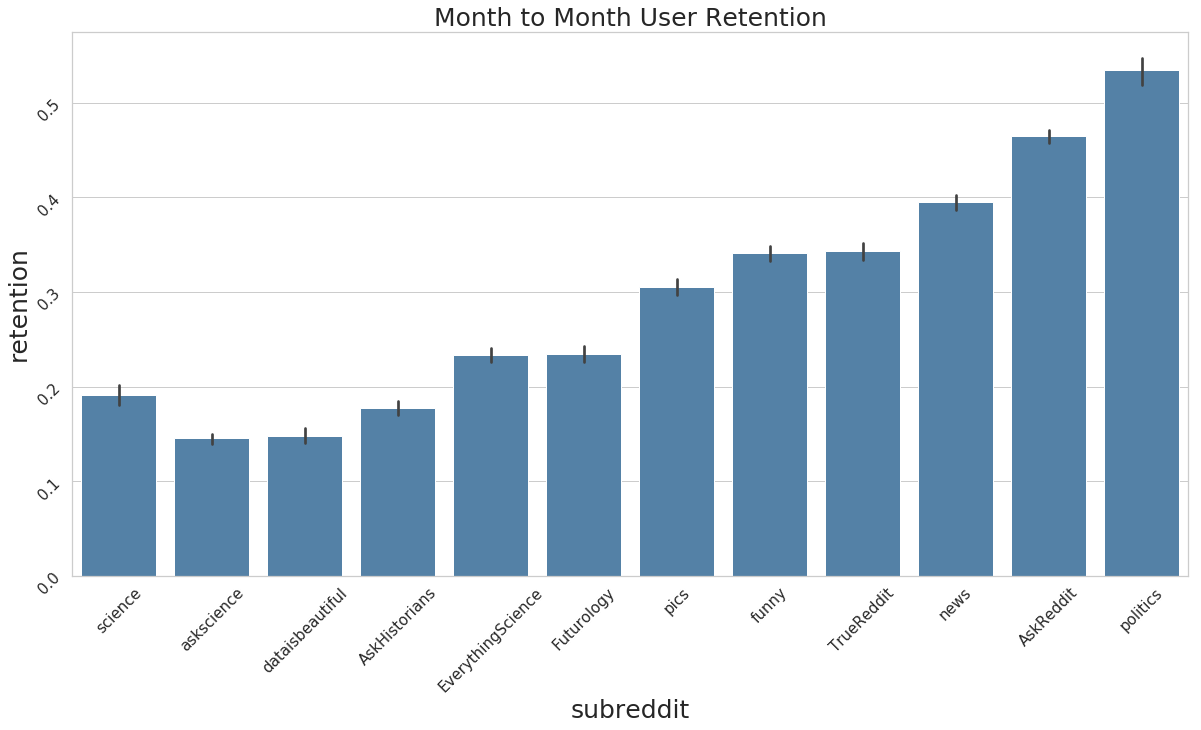

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))

ax = sns.barplot(x='sub', y='val', data=df_full_retention, color='steelblue', order=retention_order)
ax.set_ylabel('retention', fontsize='25')
ax.set_xlabel('subreddit', fontsize='25')
ax.set_title('Month to Month User Retention', fontsize='25')

ax.tick_params(axis='both', which='major', labelsize='15', rotation=45)




In [ ]:
plt.figure(figsize=(20,10))

ax = sns.barplot(x='sub', y='val', data=df_tenure)
ax.set_ylabel('tenure (months)', fontsize='25')
ax.set_xlabel('subreddit', fontsize='25')
ax.set_title('User Tenure', fontsize='25')

ax.tick_params(axis='both', which='major', labelsize='15')



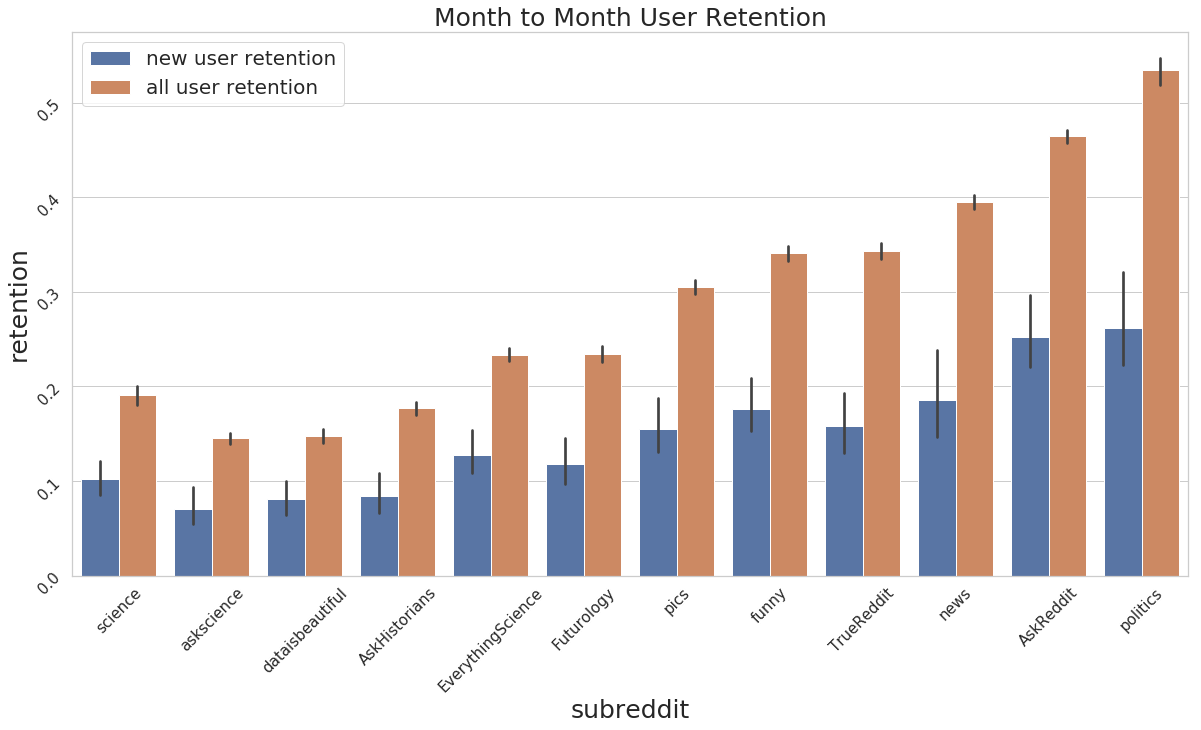

In [32]:

df_rows = pd.DataFrame(rows)
df_rows = df_rows.replace(to_replace=['new_retention' ,'full_retention'], value=['new user retention', 'all user retention'] )

sns.set(style="whitegrid")
plt.figure(figsize=(20,10))

ax = sns.barplot(x='sub', y='val', hue='kind', data=df_rows, order=retention_order)

ax.set_ylabel('retention', fontsize='25')
ax.set_xlabel('subreddit', fontsize='25')
ax.set_title('Month to Month User Retention', fontsize='25')

ax.tick_params(axis='both', which='major', labelsize='15', rotation=45)


ax.legend(fontsize='20')

In [ ]:
list(range(7, 13))

In [ ]:
s='science'
df_author_counts_2017 = pd.read_csv('data/cleaned/sub_author_counts/'+s+'_author_counts_2017.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
df_author_counts_2018 = pd.read_csv('data/cleaned/sub_author_counts/'+s+'_author_counts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')


In [ ]:
FIRST = [str(m) for m in range(1,7)] 
SECOND = [str(m) for m in range(7,13)] 


In [ ]:
def get_all_active_users(author_df, months, kind, threshold=2):
    author_df = author_df[author_df['kind'] == kind]  
    return author_df[author_df[months].sum(axis=1) >= threshold].drop_duplicates() 
    

def get_all_outside_users(author_df, months, kind, threshold=1):
    author_df = author_df[author_df['kind'] == kind]
    return author_df[author_df[months].sum(axis=1) <= threshold]


In [ ]:
print(len(get_all_active_users(df_author_counts_2017, FIRST, kind='post')))
print(len(get_all_active_users(df_author_counts_2017, SECOND, kind='post')))

print(len(get_all_active_users(df_author_counts_2017, FIRST + SECOND, kind='post'))/len(df_author_counts_2017[df_author_counts_2017['kind']=='post']))

print(len(get_all_active_users(df_author_counts_2018, FIRST, kind='post')))
print(len(get_all_active_users(df_author_counts_2018, SECOND, kind='post')))

print(len(get_all_active_users(df_author_counts_2018, FIRST + SECOND, kind='post'))/len(df_author_counts_2018[df_author_counts_2018['kind']=='post']))


In [ ]:
print(len(get_all_outside_users(df_author_counts_2017, FIRST, kind='post')))
print(len(get_all_outside_users(df_author_counts_2017, SECOND, kind='post')))

print(len(get_all_outside_users(df_author_counts_2017, FIRST + SECOND, kind='post'))/len(df_author_counts_2017[df_author_counts_2017['kind']=='post']))

print(len(get_all_outside_users(df_author_counts_2018, FIRST, kind='post')))
print(len(get_all_outside_users(df_author_counts_2018, SECOND, kind='post')))

print(len(get_all_outside_users(df_author_counts_2018, FIRST + SECOND, kind='post'))/len(df_author_counts_2018[df_author_counts_2018['kind']=='post']))


In [ ]:
# user diversity
s='science'
print('2017')
print('-----------------------------------')
print_authorship('science', year='2017')
print('-----------------------------------')
print('2018')
print_authorship('science', year='2018')

In [ ]:
for s in subs:
    print(s)
    print_authorship(s)
    print('-----------------------------------------')